<a href="https://colab.research.google.com/github/Spbhatta/Classification-of-military-aircraft-in-satellite-imagery/blob/main/Copy_of_LSTM_uav_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_data = "/content/drive/MyDrive/UAV - IISc/input_data.csv"
output_data = "/content/drive/MyDrive/UAV - IISc/target_var.csv"

In [4]:
input_size = 13 # number of input parameters
hidden_size =32 # number of hidden units in the hidden layer
num_layers = 1 # number of LSTM layers
output_size= 3 # Number of output nodes

In [5]:
input = pd.read_csv(input_data,index_col=0)
output = pd.read_csv(output_data, index_col=0)

In [6]:
print(input.shape)
print(output.shape)

in_num= input.to_numpy()
ou_num = output.to_numpy()
print("in_",in_num.shape)
print("ou",ou_num.shape)
arr=[] # stores the input data
a=[] # stores the output data


(1388600, 10)
(1388600, 3)
in_ (1388600, 10)
ou (1388600, 3)


In [7]:
print(in_num[0])

print(ou_num[0])

[ 4.47700000e-03  9.33220000e-02 -1.71400000e-03  2.20000000e-04
  3.20000000e-05 -5.77000000e-04 -2.55914213e-01 -4.54312278e-01
 -2.83487806e-01 -8.34164622e-02]
[ 0.404004 -0.351841 -0.286382]


In [8]:
seq=1 # J can be changed according the sequence size
j=1
batch_size = 1 # change according to the batch size you want to train with
k=0
for i in range(len(in_num)):
    if(j<=(len(in_num))):
        arr.append(in_num[k:j])
        a.append(ou_num[k:j])
        k+=seq
        j+=seq
class CustomDataset(Dataset):
    def __init__(self, arr, a):
        # Read the CSV file
        self.df = pd.DataFrame(arr)

        self.df2 =pd.DataFrame(a)
        # Separate features and labels (adjust column names accordingly)
        self.features = self.df.values
        self.labels = self.df2.values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.float32)
        return x, y


In [9]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 8)
        self.fc2 = nn.Linear(8, output_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(len(x), 1, -1))
        fc1_out = self.tanh(self.fc1(lstm_out[-1]))
        drop_put= self.dropout(fc1_out)
        output = self.fc2(drop_put)
        return output

In [10]:
# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size)
print(model)

LSTMModel(
  (lstm): LSTM(13, 32)
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [11]:
arr = np.array(arr)
a= np.array(a)
print(arr.shape,a.shape)
#arr= arr.reshape(1388700,10)
#a=a.reshape(1388700,3)
arr = arr.astype(np.float32)
a=a.astype(np.float32)
#inn =in_num.reshape(1388700,10)
#ou=ou_num.reshape(1388700,3)
inn = in_num
ou = ou_num
input_array = np.concatenate((arr,a),axis=2)

(1388600, 1, 10) (1388600, 1, 3)


In [12]:
# custom_dataset = CustomDataset(input_array,a)
# data_in_batches = DataLoader(custom_dataset,batch_size = batch_size,shuffle=True) #### contains the input data values along with the output data labels ( tesnors )

input_array_train, input_array_test, ou_train, ou_test = train_test_split(input_array, ou, test_size=0.2, random_state=42)


input_tensor = torch.tensor(input_array_train, dtype=torch.float32)
target_tensor = torch.tensor(ou_train, dtype=torch.float32)

input_tensor_test = torch.tensor(input_array_test, dtype=torch.float32)
target_tensor_test = torch.tensor(ou_test, dtype=torch.float32)
print(target_tensor[1].shape)


torch.Size([3])


In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
for epoch in range(1):
    running_loss = 0.0
    for i in range(len(input_tensor)):
        optimizer.zero_grad()
        output = model(input_tensor[i])
        output=output.reshape(3)
        loss = criterion(output, target_tensor[i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(input_tensor)}")
    if (epoch + 1) % 5 == 0:
        intermediate_weights_path = f'lstm_model_weights_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), intermediate_weights_path)
        print(f"Intermediate weights saved at epoch {epoch+1}: {intermediate_weights_path}")


Epoch 1, Loss: 0.0098219160748347


In [14]:
torch.save(model.state_dict(), '/content/drive/MyDrive/lstm_model.pth')

print("the weights of the model saved successfully")

the weights of the model saved successfully


In [15]:
# Testing the model
v1=[]
v2=[]
v3=[]
actual_1=[]
actual_2=[]
actual_3=[]
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for i in range(len(input_tensor_test)):
        actual_1.append(target_tensor_test[i][0].item())
        actual_2.append(target_tensor_test[i][1].item())
        actual_3.append(target_tensor_test[i][2].item())
        output = model(input_tensor_test[i].unsqueeze(0))
        output = output.squeeze(0)
        v1.append(output[0].item())
        v2.append(output[1].item())
        v3.append(output[2].item())
        loss = criterion(output, target_tensor_test[i])
        test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(input_tensor_test)}')

Test Loss: 0.0010067083765157886


In [16]:
print(target_tensor_test[i][0].item())

1.4976941347122192


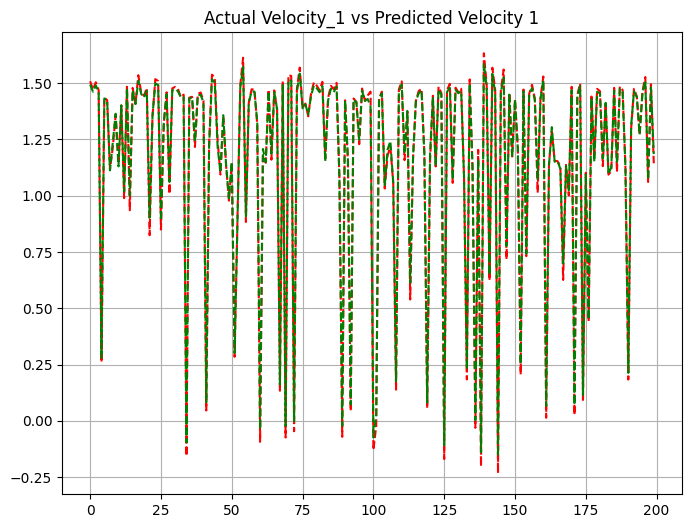

<Figure size 640x480 with 0 Axes>

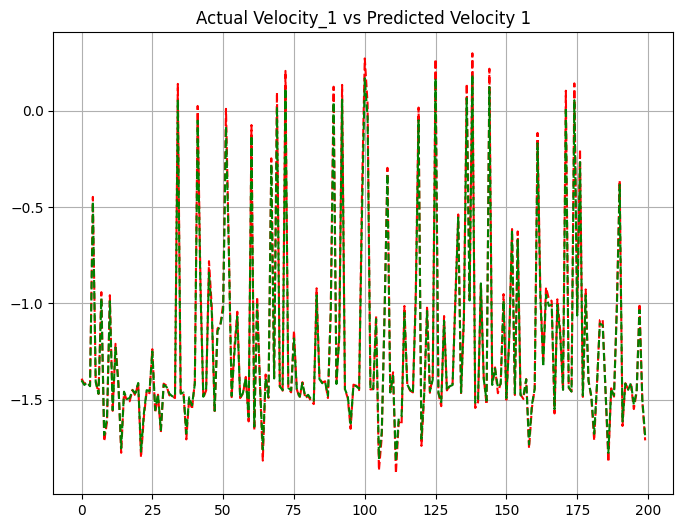

<Figure size 640x480 with 0 Axes>

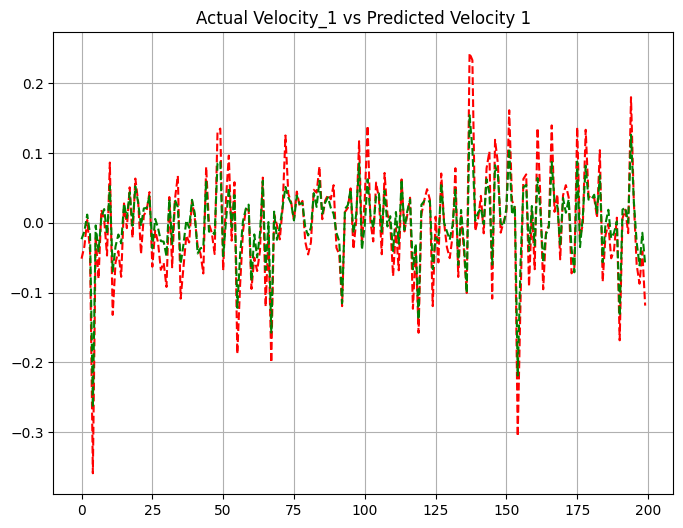

<Figure size 640x480 with 0 Axes>

In [17]:
x = [i for i in range(len(actual_1[:200]))]
plt.figure(figsize=(8, 6))
plt.plot(x,actual_1[:200], color='red', linestyle='--')
plt.plot(x,v1[:200], color='green', linestyle='--')
plt.title('Actual Velocity_1 vs Predicted Velocity 1')
plt.grid(True)
plt.show()
plt.savefig('actual_1vs_predicted_output.png')

x = [i for i in range(len(actual_2[:200]))]
plt.figure(figsize=(8, 6))
plt.plot(x,actual_2[:200], color='red', linestyle='--')
plt.plot(x,v2[:200], color='green', linestyle='--')
plt.title('Actual Velocity_1 vs Predicted Velocity 1')
plt.grid(True)
plt.show()
plt.savefig('actual_1vs_predicted_output.png')


x = [i for i in range(len(actual_3[:200]))]
plt.figure(figsize=(8, 6))
plt.plot(x,actual_3[:200], color='red', linestyle='--')
plt.plot(x,v3[:200], color='green', linestyle='--')
plt.title('Actual Velocity_1 vs Predicted Velocity 1')
plt.grid(True)
plt.show()
plt.savefig('actual_1vs_predicted_output.png')